# Complicance and Other Checks
This notebook ensures that the `UncertaintyForest` estimator is `sklearn`-compliant, and consistent with Richard's code. These checks will be incorporated into tests later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from scipy.stats import norm
from scipy.integrate import quad

# Manual forest generation.
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

## Check that Conditional Entropy estimate is consistent with Richard's code.

In [2]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(-1, n - n_1)))
  
    return X, y

def split_train_eval(X, y, frac_eval):
    
    if frac_eval == 0:
        return X, y, [], []
    
    n = len(y)
    n_eval = int(np.floor(frac_eval*n))
    eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
    X_eval = X[eval_indices, :]
    y_eval = y[eval_indices]
    X = np.delete(X, eval_indices, axis = 0)
    y = np.delete(y, eval_indices, axis = 0)
    
    return X, y, X_eval, y_eval

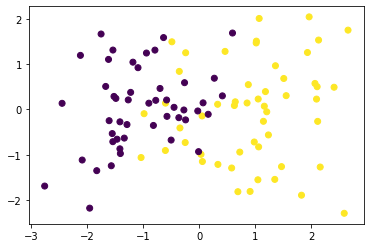

In [3]:
# Plot data.
X, y = generate_data(100, 2, mu = 1)

plt.scatter(X[:, 0], X[:, 1], c = y)

In [4]:
def true_cond_entropy(mu, base = 2.0):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

In [5]:
def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))),
                              n_estimators = n_estimators,
                              max_samples= max_samples,
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))

        total_unsampled = len(unsampled_indices)
        # print(total_unsampled)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])

        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])

        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

def uncertainty_forests_estimate(X, y, n_estimators = 300, eval_split_size = .33,
                                                  subsample_size = 0.5,
                                                  depth = 30,
                                                  min_samples_leaf = 1):
    """
    Uncertainty forest algorithm for estimating conditional entropy.
    The major steps are as follows:
    1. Split samples into EVAL and TRAIN according to eval_split_size
    2. Get subsample s from TRAIN samples according to subsample_size
    3. Split s into two partitions: STRUCT and PROB
    4. Train decision forest on STRUCT (this is just sklearn's fit function)
    5. For each tree in forest:
        i) Use PROB samples to compute probabilites in each leaf node
        ii) Perform robust finite sampling on posteriors computed by PROB samples
        iii) Use posterior to get probability that eval sample fell in leaf node
        iv) Weight eval sample probabilities by number of samples in leaf node (get class counts)
    6. Compute probabilities from class counts over entire forest
    7. Use probabilities to compute conditional entropies
    8. Return average conditional entropy over all eval samples


    Parameters
    ----------
    X: array-like
        Training samples.

    y: list
        Class labels for training samples.

    n_estimators: int
        Number of trees in forest.

    eval_split_size: float between 0 and 1
        Percent of samples to include in evaluation partition.

    subsample_size: float between 0 and 1
        Percent of non eval samples to use for a tree (subsample forms PROB and STRUCT samples).

    depth: int
        Maximum depth in tree.

    min_samples_leaf
        Minimum number of samples in node to be considered leaf.

    Returns
    -------
    Conditional entropy estimate
    """

    # split samples into eval and non eval
    # X_train, X_eval, y_train, _ = train_test_split(X, y, test_size=eval_split_size)
    X_train, y_train, X_eval, y_eval = split_train_eval(X, y, eval_split_size) # Ronak version.

    max_samples = int(X_train.shape[0]*subsample_size)
    split_samples = max_samples // 2
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth,
                              min_samples_leaf = min_samples_leaf,
                              # set default maximum features to sqrt(total features)
                              max_features = math.ceil(int(math.sqrt(X.shape[1])))),
                              n_estimators = n_estimators,
                              max_samples= split_samples,
                              bootstrap = True)

    model.fit(X_train, y_train)
    # Matrix used to compute final estimate
    # Each entry is total number of PROB nodes of class y that fell into
    # the same leaf nodes that a x_eval sample fell into.
    class_counts = np.zeros((X_eval.shape[0], model.n_classes_))
    for tree in model:

        # get total unused samples indices
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        # print(len(unsampled_indices))
        # shuffle unused sample indices
        np.random.shuffle(unsampled_indices)
        # take split_samples amount as PROB indices (honest sampling)
        prob_indices = unsampled_indices[:split_samples]

        # get all node counts in tree
        node_counts = tree.tree_.n_node_samples

        # use PROB samples to compute posterior for tree

        # NOTE: this considers probabilities for all nodes in the tree.
        # However, only leaf nodes will have relevant values
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        # for each leaf, count number of samples with each class label that fell into leaf
        # NOTE: unused leaf nodes will have probability 0 for every class

        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1

        # divide each leaf node by number of total samples that fell into leaf node
        row_sums = posterior_class_counts.sum(axis=1)
        # handle divide by 0 errors
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])

        # perform robust finite sampling
        class_probs = robust_finite_sampling(class_probs, row_sums, model.n_classes_)

        # Get probabilities from EVAL samples for final estimate
        # Weigh the probailities by number of samples in leaf node

        # Get leaf nodes counts for each sample in EVAL
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X_eval)])
        # get probability for eval samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X_eval)]
        eval_class_probs = np.array(eval_class_probs)
        # Get total elements
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    forest_probabilities = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(forest_probabilities)*forest_probabilities, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    # return sample mean
    return np.mean(entropies)


def robust_finite_sampling(class_probs, row_sums, n_classes):
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1/(n_classes*row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - (n_classes - 1)/(n_classes*row_sums[elem[0], None])
    return class_probs.tolist()

np.warnings.filterwarnings('ignore')

In [6]:
mu = 1
d = 20
sample_sizes = 2*np.array([100, 200, 300, 400])
# sample_sizes = [100]
num_trials = 10
n_estimators = 200
base = np.exp(1)

In [7]:
richard_cef = np.zeros((len(sample_sizes), num_trials))
richard_uf = np.zeros((len(sample_sizes), num_trials))
ronak = np.zeros((len(sample_sizes), num_trials))

for i, n in enumerate(sample_sizes):
    print("Sample size:", n)
    for t in range(num_trials):
        X, y = generate_data(n, d, mu = mu)
        richard_cef[i, t] = cef_estimate(X, y, n_estimators = n_estimators)
        richard_uf[i, t] = uncertainty_forests_estimate(X, y, n_estimators = n_estimators)

        uf = UncertaintyForest(n_estimators = 1, 
                               base = base, 
                               parallel = True,
                               bootstrap = True)
        uf.fit(X, y)
        ronak[i, t] = uf.estimate_cond_entropy()

Sample size: 200
70
78
82
75
69
76
70
63
65
72
68
73
70
79
75
76
75
70
72
74
72
77
78
72
77
72
70
68
80
72
75
73
73
67
73
68
71
78
73
83
72
76
78
70
74
78
74
69
69
74
82
83
76
69
77
72
72
70
75
71
70
81
75
67
80
72
74
74
68
70
79
80
81
80
76
68
75
73
71
77
72
72
83
68
72
76
68
70
76
79
73
73
73
70
81
72
74
69
67
75
67
73
76
74
76
73
72
73
67
73
72
70
80
66
64
74
69
72
78
70
77
67
69
82
67
66
66
81
85
79
82
72
69
74
68
71
68
68
67
71
73
65
76
77
70
72
76
69
72
67
75
73
80
78
74
73
70
76
71
65
76
69
63
70
62
66
80
79
69
75
70
79
77
70
67
77
70
70
65
73
70
67
71
77
75
70
64
82
83
75
72
71
74
77
72
84
70
74
66
82
74
67
67
68
74
70
65
74
66
75
76
79
67
77
73
71
72
74
74
68
76
73
73
74
73
66
75
73
74
69
74
74
80
69
69
69
65
66
72
76
82
74
73
77
74
80
76
73
77
66
69
76
70
71
72
68
77
80
72
70
74
65
75
74
85
64
68
79
83
70
68
77
67
68
78
73
77
74
71
76
77
74
69
73
80
84
68
75
71
82
69
76
83
79
82
80
71
74
75
69
76
69
67
78
73
66
71
75
74
71
77
73
74
70
76
73
80
80
79
72
78
74
70
77
79
71
72
79

76
70
72
70
71
72
74
70
78
70
78
77
61
70
67
67
73
69
71
80
82
72
76
73
70
71
74
83
76
70
83
70
71
72
69
77
78
67
73
77
69
77
76
69
68
77
71
81
70
77
72
76
74
76
68
74
71
68
78
66
71
74
69
75
75
76
74
71
70
68
72
73
70
73
76
64
77
73
71
73
72
70
69
77
73
72
58
70
73
66
72
75
83
70
73
75
72
70
72
72
69
72
73
76
75
74
74
81
72
73
72
78
77
75
65
83
71
82
72
70
71
66
74
70
74
79
68
76
75
73
75
78
65
68
75
73
72
69
75
74
74
75
69
74
69
72
73
73
72
69
77
74
80
73
68
76
74
75
60
70
72
76
67
73
74
71
73
76
80
73
72
69
72
78
82
81
63
73
75
74
77
76
75
73
78
72
78
81
72
73
77
76
74
81
67
77
74
78
76
74
84
67
68
78
69
70
78
71
75
68
75
73
71
73
71
70
73
76
77
65
68
75
78
79
70
71
74
70
72
80
74
74
80
71
73
71
72
81
75
73
66
68
78
74
77
77
74
73
74
73
74
77
70
76
72
71
72
78
67
77
70
74
80
72
70
75
72
70
74
71
77
72
76
72
79
68
69
71
72
66
68
75
72
77
74
70
69
76
70
72
70
77
70
70
73
68
76
80
69
70
74
73
73
72
75
71
70
68
78
66
70
73
71
68
72
65
64
71
77
72
65
71
74
70
74
83
74
73
70
75
68
76
75
7

137
146
141
149
152
140
156
144
136
152
151
146
153
150
136
145
146
154
150
143
150
155
151
138
160
150
154
151
135
157
160
140
146
142
160
132
148
138
146
137
140
137
151
153
133
139
149
147
139
136
150
146
146
141
150
153
155
150
150
145
137
140
149
145
148
144
139
142
149
152
143
150
153
148
145
134
141
145
144
155
145
152
149
144
151
150
146
142
150
150
151
145
144
151
141
145
153
165
149
141
154
152
145
129
155
148
135
144
145
146
157
147
148
148
165
142
147
140
149
141
142
136
147
145
160
151
139
139
144
149
142
146
145
148
145
148
152
141
146
148
142
145
148
157
150
153
151
150
143
151
146
148
163
156
147
147
148
150
150
142
156
134
151
143
142
159
149
146
143
149
143
138
148
153
148
141
141
152
145
142
147
136
140
150
146
143
140
146
141
148
139
147
149
162
154
143
144
144
144
155
145
144
152
151
151
159
154
139
140
150
144
137
130
149
147
155
138
149
149
153
157
151
142
148
146
156
155
142
144
145
150
148
151
146
151
150
141
146
146
156
156
145
148
153
147
137
147
143
140
164


142
148
152
148
147
142
148
139
162
151
153
148
151
140
142
148
139
147
147
148
144
138
147
140
143
141
144
147
154
163
145
144
141
146
152
148
136
153
144
152
155
144
148
139
142
156
136
141
154
156
137
151
145
152
139
148
137
142
151
153
151
153
141
141
152
147
152
150
145
154
150
141
147
149
143
155
150
142
147
145
147
154
150
151
146
148
153
137
139
144
152
154
153
137
146
155
144
140
149
150
150
141
138
151
144
150
147
156
146
157
149
141
150
146
146
137
148
144
146
148
145
157
149
146
155
148
143
158
157
144
163
151
140
148
152
140
135
138
144
139
151
143
142
147
151
152
160
142
142
136
164
148
153
153
143
143
153
156
132
139
151
145
137
157
154
147
148
151
141
141
148
153
136
137
150
141
138
155
158
138
158
146
132
137
140
145
145
143
155
139
143
149
149
154
148
150
142
144
150
142
150
150
154
142
151
145
153
146
150
147
145
144
152
150
144
152
139
141
148
155
140
150
151
140
147
154
143
148
158
154
135
149
153
145
152
164
143
157
146
147
153
150
149
140
135
152
149
143
149
147


228
227
222
224
217
224
221
217
230
216
220
230
229
217
229
227
224
214
224
221
220
211
208
212
220
214
224
209
238
225
222
214
213
209
218
209
224
208
216
231
215
222
209
227
217
224
219
220
230
210
220
223
224
216
225
240
213
213
227
218
229
203
222
213
216
218
225
221
208
212
218
217
232
223
209
219
213
217
228
230
213
231
223
215
226
203
204
220
220
227
211
220
226
230
210
206
212
217
211
226
222
225
215
215
217
222
212
215
219
229
218
213
236
213
227
215
215
223
225
216
216
224
208
214
214
219
236
217
217
224
226
225
215
217
213
218
219
217
226
227
199
222
214
229
219
218
229
229
212
207
211
216
212
224
203
236
222
227
214
225
228
225
221
229
225
227
210
213
227
223
224
213
209
212
228
228
221
229
238
215
219
231
225
209
225
223
237
223
231
218
226
234
232
222
229
209
218
224
217
227
208
221
220
221
225
232
215
217
218
223
213
220
226
243
210
231
237
220
212
233
227
224
218
215
212
230
217
221
213
217
236
218
211
221
223
230
224
225
232
213
228
221
222
230
216
223
213
231
227
224


225
217
218
231
237
223
212
229
213
221
208
222
206
225
219
221
209
227
219
206
216
218
218
220
232
217
223
217
219
221
215
221
226
204
223
208
218
225
227
220
230
211
218
216
220
230
228
226
227
212
220
211
223
211
213
214
218
214
216
212
224
218
220
224
222
216
219
218
241
224
225
224
225
233
203
208
204
229
206
222
214
234
223
232
222
225
212
214
215
217
216
220
228
226
232
217
222
216
211
218
218
211
213
213
214
215
220
232
212
215
221
216
217
229
214
238
215
217
212
226
234
217
217
221
216
217
219
221
221
230
227
214
217
205
217
221
219
223
219
232
229
216
213
230
217
210
212
210
225
219
226
214
218
214
223
221
212
227
214
219
216
230
210
227
213
235
223
233
218
221
222
222
222
219
243
222
232
222
229
220
243
222
213
216
223
214
209
221
228
214
208
222
232
217
226
211
223
220
227
219
220
215
222
221
227
204
229
218
211
228
229
225
209
213
220
210
221
215
218
206
226
211
212
237
211
213
218
212
220
222
225
220
208
206
208
212
208
233
207
214
222
215
214
214
223
245
216
214
212
226


300
307
296
320
294
290
286
282
300
300
285
282
284
290
302
289
298
293
291
296
296
286
288
288
302
295
280
288
278
298
285
304
295
303
298
292
294
289
291
299
293
297
283
301
289
297
303
294
291
287
296
296
300
296
307
284
302
290
299
287
280
290
280
284
293
286
280
299
287
289
286
301
288
289
285
288
297
316
288
287
284
301
296
301
297
300
294
285
298
293
286
289
297
306
287
305
280
280
303
283
300
319
292
291
312
282
293
289
280
307
314
290
276
294
285
288
295
280
298
290
300
286
291
303
293
282
303
292
284
298
288
299
300
288
277
296
288
300
288
289
312
306
291
273
295
296
280
298
284
292
284
288
284
294
297
285
288
296
292
312
300
300
293
305
296
306
295
300
289
297
300
295
292
297
284
304
302
292
289
312
288
291
292
274
293
288
299
268
286
288
309
283
298
294
286
304
310
293
293
272
305
280
305
307
300
302
296
284
286
295
304
291
277
305
290
289
299
300
284
278
288
288
296
306
286
288
295
295
285
299
283
292
294
304
298
294
295
293
309
292
294
306
288
291
280
283
293
293
295
296


294
298
307
296
292
307
290
275
289
287
299
318
298
284
286
288
303
285
293
292
300
287
298
302
291
292
296
302
304
278
300
274
296
304
290
303
294
303
301
283
299
297
287
303
293
285
297
297
301
294
298
300
295
304
305
304
291
289
296
290
289
276
300
301
287
293
272
294
305
298
296
310
310
293
285
298
284
292
294
303
298
306
288
301
306
290
296
296
290
289
303
307
302
303
291
293
303
301
302
281
305
277
301
303
306
301
310
284
303
302
305
287
312
292
300
298
289
300
301
289
291
271
299
294
302
296
290
287
278
286
317
293
290
288
295
286
293
291
292
284
303
290
305
305
292
269
293
306
286
288
285
295
281
288
290
310
309
298
303
308
300
311
298
293
280
292
289
281
292
291
298
302
284
291
298
294
296
298
290
300
287
302
297
311
298
293
296
296
296
290
296
296
304
299
284
305
283
278
292
305
284
275
290
290
309
283
293
302
278
303
284
296
304
292
300
286
305
304
282
292
298
308
301
290
282
298
294
291
300
281
300
290
273
286
304
291
302
293
298
289
295
301
293
289
294
304
294
300
308
299


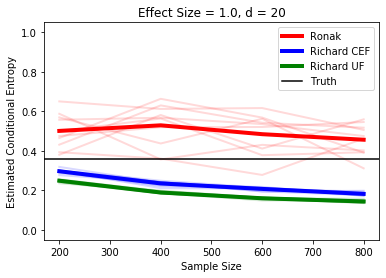

In [9]:
plt.plot(sample_sizes,
         np.mean(ronak, axis = 1).flatten(), 
         label = 'Ronak', 
         linewidth = 4, 
         color = 'red')
for t in range(num_trials):
    plt.plot(sample_sizes, 
    ronak[:, t].flatten(),  
    linewidth = 2, 
    color = 'red',
    alpha = 0.15)
plt.plot(sample_sizes,
         np.mean(richard_cef, axis = 1).flatten(), 
         label = 'Richard CEF', 
         linewidth = 4, 
         color = 'blue')
for t in range(num_trials):
    plt.plot(sample_sizes, 
    richard_cef[:, t].flatten(),  
    linewidth = 2, 
    color = 'blue',
    alpha = 0.15)
plt.plot(sample_sizes,
         np.mean(richard_uf, axis = 1).flatten(), 
         label = 'Richard UF', 
         linewidth = 4, 
         color = 'green')
for t in range(num_trials):
    plt.plot(sample_sizes, 
    richard_uf[:, t].flatten(),  
    linewidth = 2, 
    color = 'green',
    alpha = 0.15)

truth = true_cond_entropy(mu, base = np.exp(1))
plt.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")

plt.xlabel("Sample Size")
plt.ylabel("Estimated Conditional Entropy")
plt.title("Effect Size = %.1f, d = %d" % (mu, d))
plt.legend(loc = "upper right")
plt.ylim(ymin = -0.05, ymax = 1.05)
plt.show()